# Faster R-CNN Model Comparison & Evaluation
## Fine-tuned vs Baseline Performance Analysis

This notebook evaluates and compares:
1. **Fine-tuned model** - Your trained model with pretrained weights
2. **Pretrained baseline** - COCO pretrained model (no fine-tuning)
3. **From-scratch baseline** - Model trained without pretrained weights (optional)

**Metrics evaluated:**
- Detection accuracy (mAP, AP@0.50, AP@0.75)
- Inference speed (FPS, latency)
- Model size and memory usage
- Precision-Recall curves
- Per-class performance

## 1. Setup and Imports

In [1]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import time
import json
import pandas as pd
from collections import defaultdict
import copy
import warnings
warnings.filterwarnings('ignore')

# Import from your training script
from train_rcnn import COCODataset, get_transform, collate_fn
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 2070


## 2. Configuration

In [ ]:
# Paths 
DATA_DIR = Path('./data')
FINETUNED_MODEL_PATH = Path('./runs/rcnn/latest.pt')  
SCRATCH_MODEL_PATH = Path('./runs/rcnn_scratch/latest.pt')  

# Evaluation settings
BATCH_SIZE = 4
NUM_WORKERS = 4
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

# Speed benchmarking
WARMUP_ITERATIONS = 10
BENCHMARK_ITERATIONS = 100

print(f"Device: {DEVICE}")
print(f"Data directory: {DATA_DIR}")
print(f"Fine-tuned model: {FINETUNED_MODEL_PATH}")
print(f"NOTE: Using latest.pt checkpoint (not best.pt)")

Device: cuda
Data directory: data
Fine-tuned model: runs\rcnn\latest.pt
NOTE: Using latest.pt checkpoint (not best.pt)


## 3. Load Dataset

In [ ]:
# Load validation dataset 
print("Loading validation dataset...")


EVAL_JSON = DATA_DIR / 'val.json' 
EVAL_IMG_DIR = DATA_DIR / 'val'    

val_dataset = COCODataset(
    json_file=EVAL_JSON,
    img_dir=EVAL_IMG_DIR,
    transforms=get_transform(train=False)
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)

print(f"Validation set: {len(val_dataset)} images")
print(f"Batches: {len(val_loader)}")

coco_gt = val_dataset.coco

# Fix missing COCO fields
if 'info' not in coco_gt.dataset:
    print("  Adding missing 'info' field to COCO dataset...")
    coco_gt.dataset['info'] = {
        'description': 'Custom Car Detection Dataset',
        'version': '1.0',
        'year': 2025,
        'contributor': 'JXOHG',
        'date_created': '2025-11-19'
    }

if 'licenses' not in coco_gt.dataset:
    print("  Adding missing 'licenses' field to COCO dataset...")
    coco_gt.dataset['licenses'] = []

total_annotations = len(coco_gt.getAnnIds())
print(f"Total ground truth boxes: {total_annotations}")

Loading validation dataset...
Loading annotations from data\val.json...
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
   Valid images: 198
   Total annotations: 8509
   Avg boxes/image: 42.97
Loaded 198 images from data\val.json
Validation set: 198 images
Batches: 50
  Adding missing 'info' field to COCO dataset...
  Adding missing 'licenses' field to COCO dataset...
Total ground truth boxes: 8509


## 4. Load Models

In [4]:
def load_finetuned_model(checkpoint_path, device):
    print(f"Loading fine-tuned model from {checkpoint_path}...")
    model = fasterrcnn_resnet50_fpn_v2(weights=None)
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    epoch = checkpoint['epoch']
    metrics = checkpoint.get('metrics', {})
    print(f"  Loaded from epoch {epoch}")
    if 'val_ap50' in metrics:
        print(f"  Training AP@0.50: {metrics['val_ap50']:.4f}")
    return model, metrics

def load_pretrained_baseline(device):
    print("Loading pretrained baseline (COCO weights)...")
    weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn_v2(weights=weights)
    model.to(device)
    model.eval()
    print("  Pretrained on COCO (80 classes)")
    return model

def get_model_size(model):
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024**2

models = {}

if FINETUNED_MODEL_PATH.exists():
    finetuned_model, finetuned_train_metrics = load_finetuned_model(FINETUNED_MODEL_PATH, DEVICE)
    models['Fine-tuned'] = finetuned_model
    print(f"  Model size: {get_model_size(finetuned_model):.2f} MB\n")
else:
    print(f"  Warning: Fine-tuned model not found at {FINETUNED_MODEL_PATH}\n")

pretrained_model = load_pretrained_baseline(DEVICE)
models['Pretrained (COCO)'] = pretrained_model
print(f"  Model size: {get_model_size(pretrained_model):.2f} MB\n")

if SCRATCH_MODEL_PATH.exists():
    scratch_model, scratch_train_metrics = load_finetuned_model(SCRATCH_MODEL_PATH, DEVICE)
    models['From Scratch'] = scratch_model
    print(f"  Model size: {get_model_size(scratch_model):.2f} MB\n")

print(f"Total models to evaluate: {len(models)}")

Loading fine-tuned model from runs\rcnn\latest.pt...
  Loaded from epoch 1
  Training AP@0.50: 0.0000
  Model size: 165.24 MB

Loading pretrained baseline (COCO weights)...
  Pretrained on COCO (80 classes)
  Model size: 166.98 MB

Total models to evaluate: 2


## 5. Evaluation Functions

In [ ]:
@torch.no_grad()
def evaluate_accuracy(model, data_loader, coco_gt, device, model_name="Model", is_coco_pretrained=False):
    model.eval()
    coco_results = []
    num_predictions = 0
    num_images = 0
    
    # Debug info
    label_counts = defaultdict(int)
    all_scores = []
    
    print(f"Evaluating {model_name}...")
    print(f"  Processing {len(data_loader)} batches...")
    
    for batch_idx, (images, targets) in enumerate(data_loader):
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch {batch_idx + 1}/{len(data_loader)}")
        
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for target, output in zip(targets, outputs):
            image_id = target['image_id'].item()
            num_images += 1
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            
            # Filter by class and score
            if is_coco_pretrained:
                mask = (labels == 3) & (scores > 0.05)  # COCO car class
            else:
                mask = (labels == 1) & (scores > 0.05)  # Fine-tuned car class
            
            boxes = boxes[mask]
            scores = scores[mask]
            labels_filtered = labels[mask]
            
            # Track label distribution
            for label in labels_filtered:
                label_counts[int(label)] += 1
            
            for box, score in zip(boxes, scores):
                x1, y1, x2, y2 = box
                w, h = x2 - x1, y2 - y1
                if w > 0 and h > 0:
                    coco_results.append({
                        'image_id': int(image_id),
                        'category_id': 1,  # Always 1 for car in our dataset
                        'bbox': [float(x1), float(y1), float(w), float(h)],
                        'score': float(score)
                    })
                    num_predictions += 1
                    all_scores.append(float(score))
    
    print(f"  Total predictions: {num_predictions}")
    print(f"  Avg predictions/image: {num_predictions/num_images:.2f}")
    
    # Debug information
    if num_predictions > 0:
        print(f"\n   Debug Info:")
        print(f"     Label distribution (before filtering): {dict(label_counts)}")
        print(f"     Score range: {min(all_scores):.4f} - {max(all_scores):.4f}")
        print(f"     Mean score: {np.mean(all_scores):.4f}")
        print(f"     Median score: {np.median(all_scores):.4f}")
        print(f"     First 3 predictions:")
        for i in range(min(3, len(coco_results))):
            r = coco_results[i]
            print(f"       Image {r['image_id']}, Score: {r['score']:.4f}, Cat: {r['category_id']}")
    
    if len(coco_results) == 0:
        print("    Warning: No predictions made!")
        return {
            'mAP': 0.0, 'AP50': 0.0, 'AP75': 0.0, 
            'AP_small': 0.0, 'AP_medium': 0.0, 'AP_large': 0.0,
            'AR_max1': 0.0, 'AR_max10': 0.0, 'AR_max100': 0.0,
            'AR_small': 0.0, 'AR_medium': 0.0, 'AR_large': 0.0,
            'predictions': [],
            'precision': None,
            'recall': None
        }
    
    try:
        print("  Running COCO evaluation...")
        coco_dt = coco_gt.loadRes(coco_results)
        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
        
        # Safely extract precision and recall
        precision = None
        recall = None
        if hasattr(coco_eval, 'eval') and coco_eval.eval is not None:
            if 'precision' in coco_eval.eval:
                precision = coco_eval.eval['precision']
            if 'recall' in coco_eval.eval:
                recall = coco_eval.eval['recall']
        
        return {
            'mAP': coco_eval.stats[0],
            'AP50': coco_eval.stats[1],
            'AP75': coco_eval.stats[2],
            'AP_small': coco_eval.stats[3],
            'AP_medium': coco_eval.stats[4],
            'AP_large': coco_eval.stats[5],
            'AR_max1': coco_eval.stats[6],
            'AR_max10': coco_eval.stats[7],
            'AR_max100': coco_eval.stats[8],
            'AR_small': coco_eval.stats[9],
            'AR_medium': coco_eval.stats[10],
            'AR_large': coco_eval.stats[11],
            'predictions': coco_results,
            'precision': precision,
            'recall': recall
        }
    except Exception as e:
        print(f"    Warning: Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        return {
            'mAP': 0.0, 'AP50': 0.0, 'AP75': 0.0,
            'AP_small': 0.0, 'AP_medium': 0.0, 'AP_large': 0.0,
            'AR_max1': 0.0, 'AR_max10': 0.0, 'AR_max100': 0.0,
            'AR_small': 0.0, 'AR_medium': 0.0, 'AR_large': 0.0,
            'predictions': coco_results,
            'precision': None,
            'recall': None
        }

@torch.no_grad()
def measure_inference_speed(model, data_loader, device, model_name="Model", warmup_iters=10, benchmark_iters=100):
    model.eval()
    print(f"Measuring inference speed for {model_name}...")
    
    images, _ = next(iter(data_loader))
    images = [img.to(device) for img in images]
    batch_size = len(images)
    
    print(f"  Warming up ({warmup_iters} iterations)...")
    for i in range(warmup_iters):
        _ = model(images)
        if (i + 1) % 5 == 0:
            print(f"    Warmup {i + 1}/{warmup_iters}")
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    print(f"  Benchmarking ({benchmark_iters} iterations)...")
    latencies = []
    
    for i in range(benchmark_iters):
        if (i + 1) % 25 == 0:
            print(f"    Benchmark {i + 1}/{benchmark_iters}")
        
        start_time = time.perf_counter()
        _ = model(images)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end_time = time.perf_counter()
        latencies.append(end_time - start_time)
    
    latencies = np.array(latencies)
    
    return {
        'batch_size': batch_size,
        'mean_latency_ms': np.mean(latencies) * 1000,
        'std_latency_ms': np.std(latencies) * 1000,
        'min_latency_ms': np.min(latencies) * 1000,
        'max_latency_ms': np.max(latencies) * 1000,
        'p50_latency_ms': np.percentile(latencies, 50) * 1000,
        'p95_latency_ms': np.percentile(latencies, 95) * 1000,
        'p99_latency_ms': np.percentile(latencies, 99) * 1000,
        'batch_fps': batch_size / np.mean(latencies),
        'single_image_fps': 1.0 / (np.mean(latencies) / batch_size),
        'latencies_all': latencies
    }

def calculate_memory_usage(model, device):
    if not torch.cuda.is_available():
        return {'memory_mb': 0, 'memory_gb': 0}
    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.synchronize()
    dummy_input = [torch.randn(3, 640, 640).to(device)]
    with torch.no_grad():
        _ = model(dummy_input)
    torch.cuda.synchronize()
    memory_bytes = torch.cuda.max_memory_allocated(device)
    return {'memory_mb': memory_bytes / 1024**2, 'memory_gb': memory_bytes / 1024**3}

print("Evaluation functions loaded.")

Evaluation functions loaded.


## 6. Run Evaluation

In [6]:
results = {}

for model_name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*70}\n")
    
    is_coco = (model_name == 'Pretrained (COCO)')
    
    print("[1/3] Measuring accuracy...")
    accuracy_metrics = evaluate_accuracy(model, val_loader, coco_gt, DEVICE, model_name, is_coco)
    
    print(f"\n[2/3] Measuring inference speed...")
    speed_metrics = measure_inference_speed(model, val_loader, DEVICE, model_name, WARMUP_ITERATIONS, BENCHMARK_ITERATIONS)
    
    print(f"\n[3/3] Measuring memory usage...")
    memory_metrics = calculate_memory_usage(model, DEVICE)
    
    results[model_name] = {
        'accuracy': accuracy_metrics,
        'speed': speed_metrics,
        'memory': memory_metrics,
        'model_size_mb': get_model_size(model)
    }
    
    print(f"\n{'='*70}")
    print(f"{model_name} - Summary")
    print(f"{'='*70}")
    print(f"Accuracy:")
    print(f"  mAP@[.5:.95]: {accuracy_metrics['mAP']:.4f}")
    print(f"  AP@0.50:      {accuracy_metrics['AP50']:.4f}")
    print(f"  AP@0.75:      {accuracy_metrics['AP75']:.4f}")
    print(f"\nSpeed:")
    print(f"  Batch FPS:    {speed_metrics['batch_fps']:.2f}")
    print(f"  Single FPS:   {speed_metrics['single_image_fps']:.2f}")
    print(f"  Latency (ms): {speed_metrics['mean_latency_ms']:.2f} ± {speed_metrics['std_latency_ms']:.2f}")
    print(f"\nMemory:")
    print(f"  Model size:   {get_model_size(model):.2f} MB")
    if torch.cuda.is_available():
        print(f"  GPU memory:   {memory_metrics['memory_mb']:.2f} MB")
    print(f"{'='*70}\n")

print("\n All evaluations complete!")


Evaluating: Fine-tuned

[1/3] Measuring accuracy...
Evaluating Fine-tuned...
  Processing 50 batches...
  Batch 10/50
  Batch 20/50
  Batch 30/50
  Batch 40/50
  Batch 50/50
  Total predictions: 11147
  Avg predictions/image: 56.30

  🔍 Debug Info:
     Label distribution (before filtering): {1: 11147}
     Score range: 0.0500 - 0.9987
     Mean score: 0.7952
     Median score: 0.9883
     First 3 predictions:
       Image 692, Score: 0.9986, Cat: 1
       Image 692, Score: 0.9980, Cat: 1
       Image 692, Score: 0.9970, Cat: 1
  Running COCO evaluation...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.05s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDet

## 7. Comparison Tables

In [7]:
accuracy_data = []
for model_name, result in results.items():
    acc = result['accuracy']
    accuracy_data.append({
        'Model': model_name,
        'mAP@[.5:.95]': f"{acc['mAP']:.4f}",
        'AP@0.50': f"{acc['AP50']:.4f}",
        'AP@0.75': f"{acc['AP75']:.4f}",
        'AP (small)': f"{acc.get('AP_small', 0):.4f}",
        'AP (medium)': f"{acc.get('AP_medium', 0):.4f}",
        'AP (large)': f"{acc.get('AP_large', 0):.4f}",
        'AR@100': f"{acc.get('AR_max100', 0):.4f}"
    })

df_accuracy = pd.DataFrame(accuracy_data)
print("\n" + "="*90)
print("ACCURACY COMPARISON")
print("="*90)
print(df_accuracy.to_string(index=False))

speed_data = []
for model_name, result in results.items():
    spd = result['speed']
    speed_data.append({
        'Model': model_name,
        'Single Image FPS': f"{spd['single_image_fps']:.2f}",
        'Batch FPS': f"{spd['batch_fps']:.2f}",
        'Mean Latency (ms)': f"{spd['mean_latency_ms']:.2f}",
        'P95 Latency (ms)': f"{spd['p95_latency_ms']:.2f}",
        'P99 Latency (ms)': f"{spd['p99_latency_ms']:.2f}"
    })

df_speed = pd.DataFrame(speed_data)
print("\n" + "="*90)
print("SPEED COMPARISON")
print("="*90)
print(df_speed.to_string(index=False))

resource_data = []
for model_name, result in results.items():
    mem = result['memory']
    resource_data.append({
        'Model': model_name,
        'Model Size (MB)': f"{result['model_size_mb']:.2f}",
        'GPU Memory (MB)': f"{mem['memory_mb']:.2f}" if torch.cuda.is_available() else 'N/A'
    })

df_resources = pd.DataFrame(resource_data)
print("\n" + "="*90)
print("RESOURCE USAGE COMPARISON")
print("="*90)
print(df_resources.to_string(index=False))

if 'Fine-tuned' in results and 'Pretrained (COCO)' in results:
    print("\n" + "="*90)
    print("IMPROVEMENT (Fine-tuned vs Pretrained COCO)")
    print("="*90)
    
    ft = results['Fine-tuned']
    baseline = results['Pretrained (COCO)']
    improvements = []
    
    for metric in ['mAP', 'AP50', 'AP75']:
        ft_val = ft['accuracy'][metric]
        bl_val = baseline['accuracy'][metric]
        improvement = ((ft_val - bl_val) / bl_val) * 100 if bl_val > 0 else float('inf')
        improvements.append({
            'Metric': metric,
            'Baseline': f"{bl_val:.4f}",
            'Fine-tuned': f"{ft_val:.4f}",
            'Absolute Diff': f"{ft_val - bl_val:+.4f}",
            'Improvement': f"{improvement:+.2f}%" if improvement != float('inf') else 'N/A'
        })
    
    df_improvements = pd.DataFrame(improvements)
    print(df_improvements.to_string(index=False))
    print("="*90)


ACCURACY COMPARISON
            Model mAP@[.5:.95] AP@0.50 AP@0.75 AP (small) AP (medium) AP (large) AR@100
       Fine-tuned       0.7742  0.9889  0.9613     0.1735      0.7754     0.7798 0.8201
Pretrained (COCO)       0.0024  0.0119  0.0010     0.0000      0.0029     0.1189 0.0089

SPEED COMPARISON
            Model Single Image FPS Batch FPS Mean Latency (ms) P95 Latency (ms) P99 Latency (ms)
       Fine-tuned             7.97      7.97            502.01           512.38           516.51
Pretrained (COCO)             7.83      7.83            510.97           520.47           526.81

RESOURCE USAGE COMPARISON
            Model Model Size (MB) GPU Memory (MB)
       Fine-tuned          165.24          841.32
Pretrained (COCO)          166.98          848.59

IMPROVEMENT (Fine-tuned vs Pretrained COCO)
Metric Baseline Fine-tuned Absolute Diff Improvement
   mAP   0.0024     0.7742       +0.7718  +31716.21%
  AP50   0.0119     0.9889       +0.9770   +8186.24%
  AP75   0.0010     0.961

## 8. Visualization - Accuracy Comparison

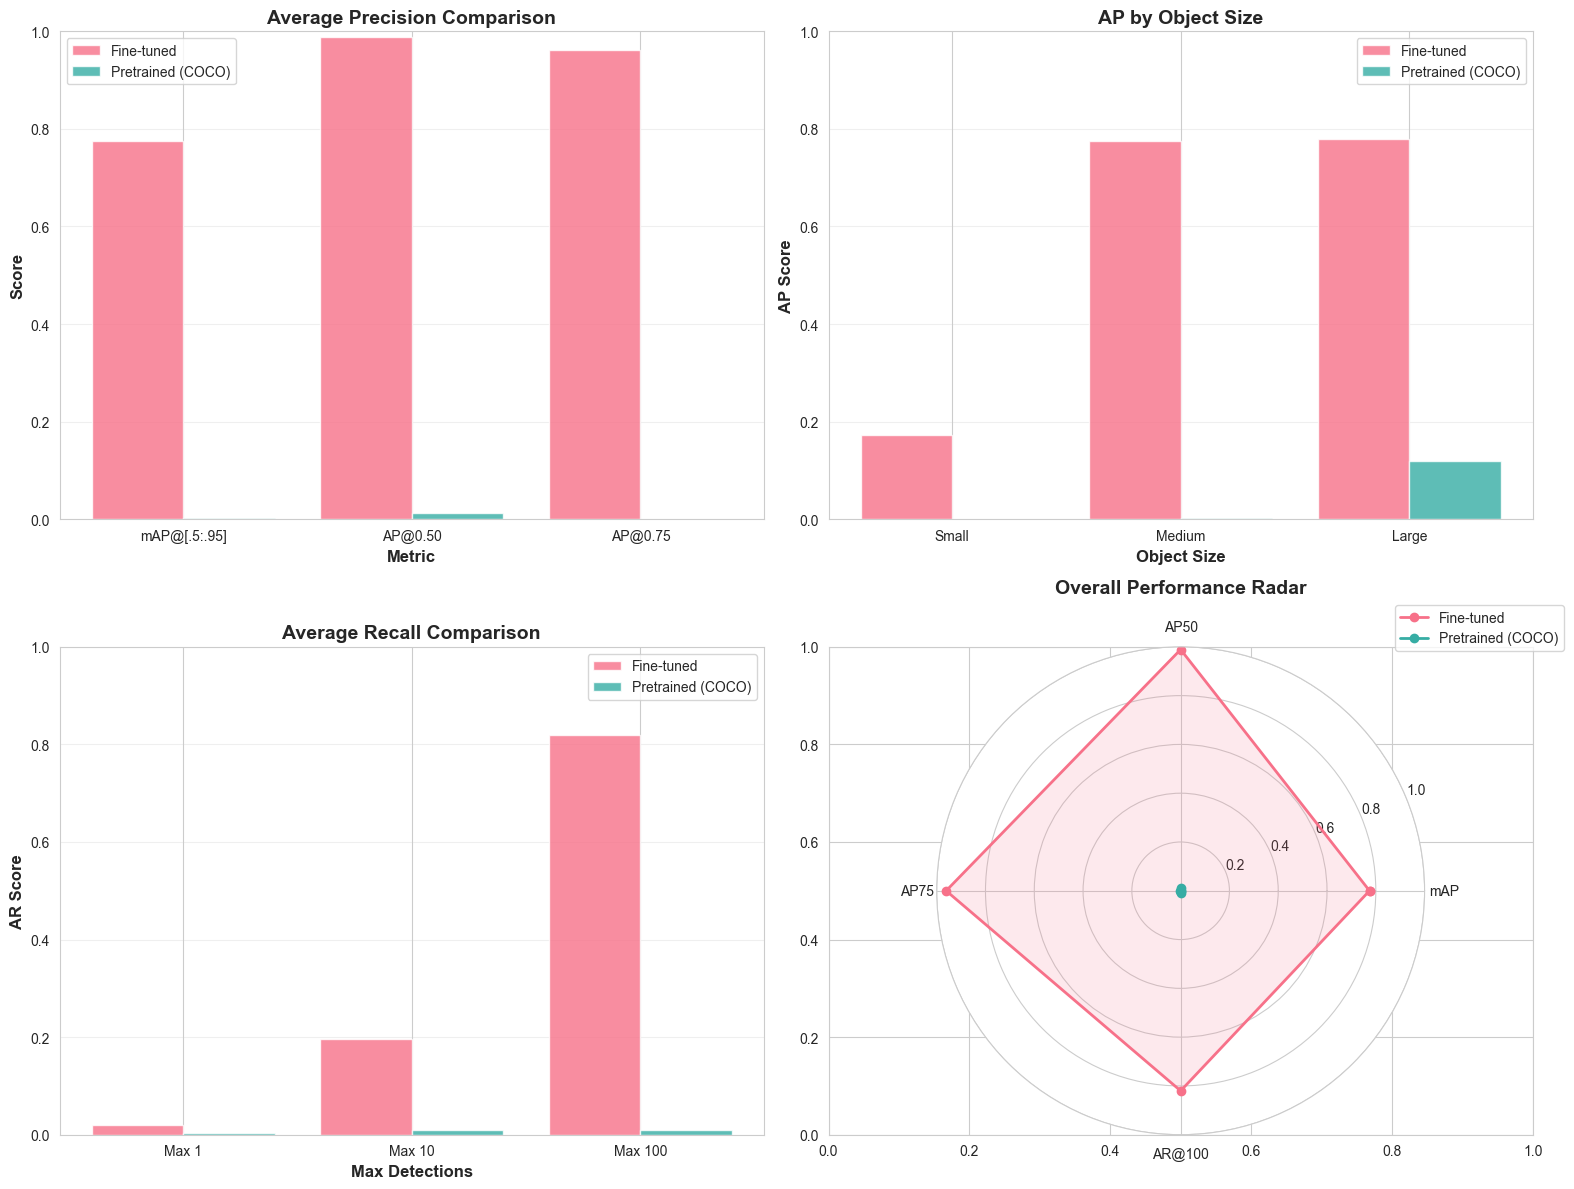

 Accuracy comparison plots saved


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
model_names = list(results.keys())
colors = sns.color_palette("husl", len(model_names))

# Main AP metrics
ax = axes[0, 0]
metrics = ['mAP', 'AP50', 'AP75']
x = np.arange(len(metrics))
width = 0.8 / len(model_names)

for i, (model_name, color) in enumerate(zip(model_names, colors)):
    values = [results[model_name]['accuracy'][m] for m in metrics]
    ax.bar(x + i * width, values, width, label=model_name, color=color, alpha=0.8)

ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Average Precision Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(['mAP@[.5:.95]', 'AP@0.50', 'AP@0.75'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

# AP by object size
ax = axes[0, 1]
size_metrics = ['AP_small', 'AP_medium', 'AP_large']
x = np.arange(len(size_metrics))

for i, (model_name, color) in enumerate(zip(model_names, colors)):
    values = [results[model_name]['accuracy'].get(m, 0) for m in size_metrics]
    ax.bar(x + i * width, values, width, label=model_name, color=color, alpha=0.8)

ax.set_xlabel('Object Size', fontsize=12, fontweight='bold')
ax.set_ylabel('AP Score', fontsize=12, fontweight='bold')
ax.set_title('AP by Object Size', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(['Small', 'Medium', 'Large'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

# Average Recall
ax = axes[1, 0]
ar_metrics = ['AR_max1', 'AR_max10', 'AR_max100']
x = np.arange(len(ar_metrics))

for i, (model_name, color) in enumerate(zip(model_names, colors)):
    values = [results[model_name]['accuracy'].get(m, 0) for m in ar_metrics]
    ax.bar(x + i * width, values, width, label=model_name, color=color, alpha=0.8)

ax.set_xlabel('Max Detections', fontsize=12, fontweight='bold')
ax.set_ylabel('AR Score', fontsize=12, fontweight='bold')
ax.set_title('Average Recall Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(['Max 1', 'Max 10', 'Max 100'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

# Radar chart
ax = plt.subplot(2, 2, 4, projection='polar')
categories = ['mAP', 'AP50', 'AP75', 'AR@100']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

for model_name, color in zip(model_names, colors):
    values = [
        results[model_name]['accuracy']['mAP'],
        results[model_name]['accuracy']['AP50'],
        results[model_name]['accuracy']['AP75'],
        results[model_name]['accuracy'].get('AR_max100', 0)
    ]
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_title('Overall Performance Radar', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Accuracy comparison plots saved")

## 9. Visualization - Speed & Efficiency

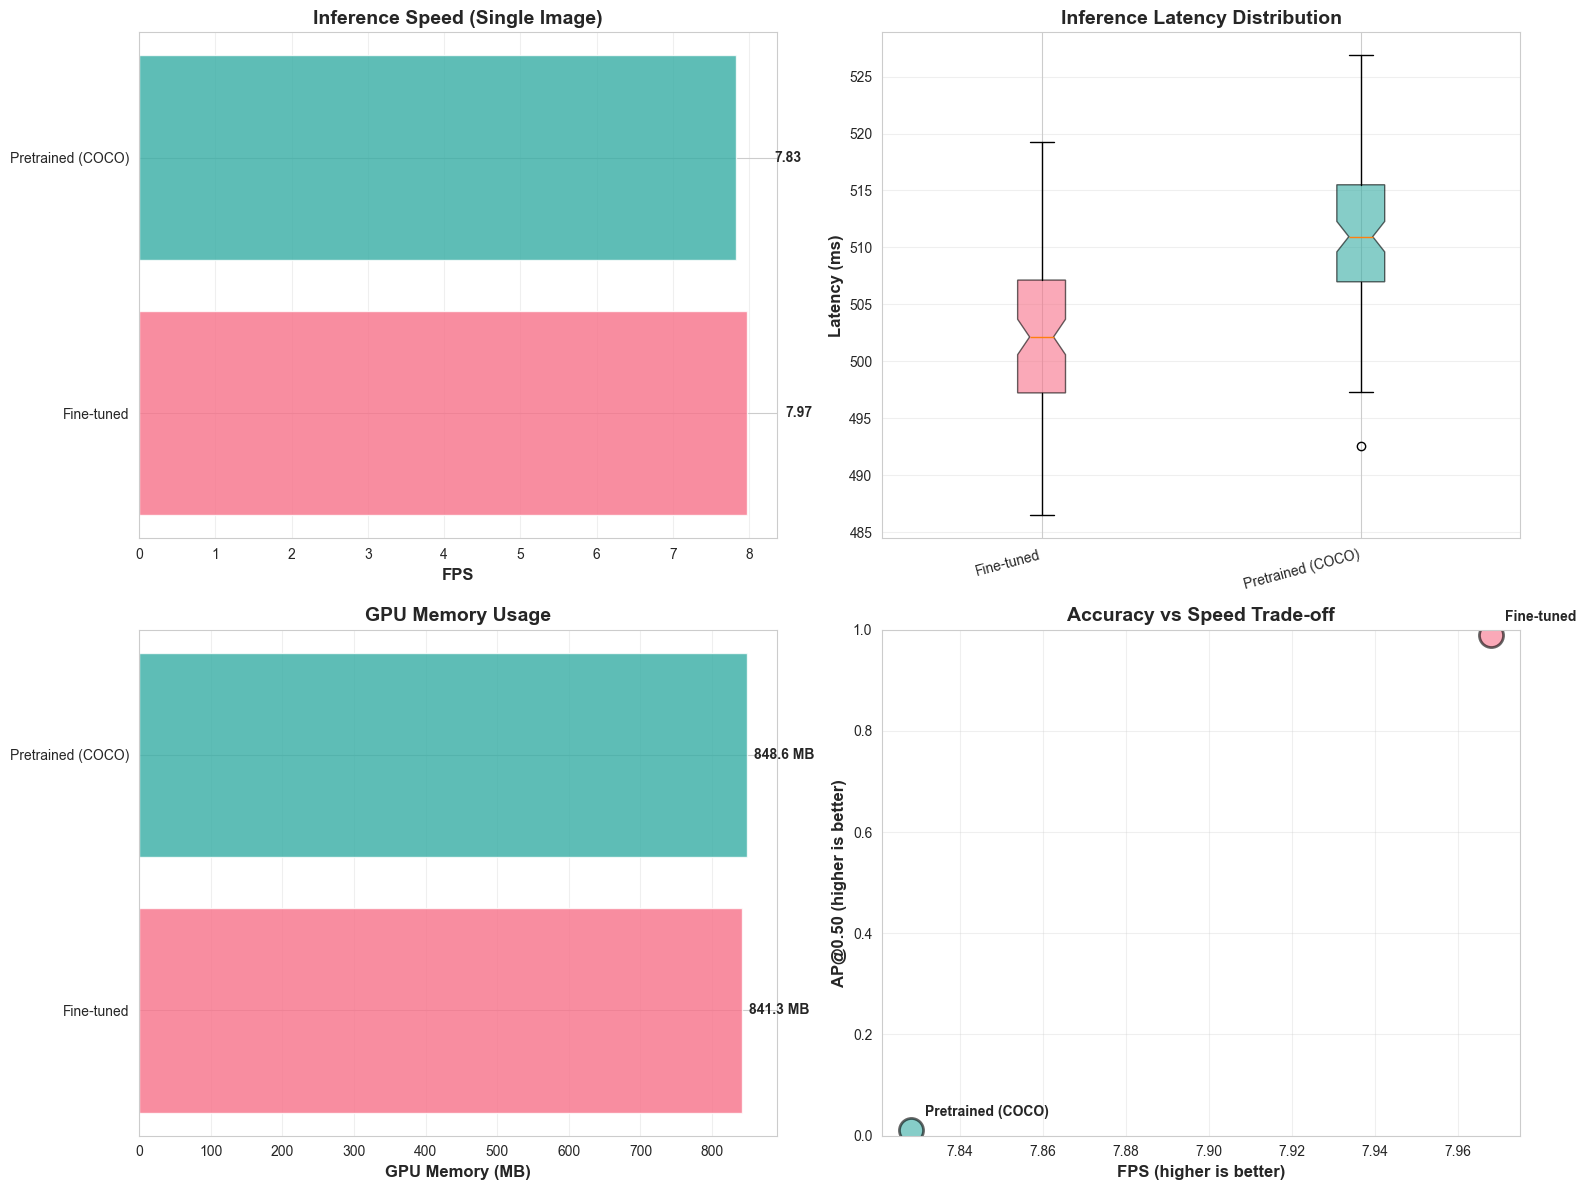

 Speed & efficiency plots saved


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# FPS Comparison
ax = axes[0, 0]
fps_data = [(name, results[name]['speed']['single_image_fps']) for name in model_names]
names, fps = zip(*fps_data)
bars = ax.barh(names, fps, color=colors, alpha=0.8)
ax.set_xlabel('FPS', fontsize=12, fontweight='bold')
ax.set_title('Inference Speed (Single Image)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, fps)):
    ax.text(val + 0.5, i, f'{val:.2f}', va='center', fontweight='bold')

# Latency Distribution
ax = axes[0, 1]
latency_data = [results[name]['speed']['latencies_all'] * 1000 for name in model_names]
bp = ax.boxplot(latency_data, labels=model_names, patch_artist=True, notch=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax.set_ylabel('Latency (ms)', fontsize=12, fontweight='bold')
ax.set_title('Inference Latency Distribution', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=15, ha='right')

# Memory Usage
ax = axes[1, 0]
if torch.cuda.is_available():
    memory_data = [(name, results[name]['memory']['memory_mb']) for name in model_names]
    names, mem = zip(*memory_data)
    bars = ax.barh(names, mem, color=colors, alpha=0.8)
    ax.set_xlabel('GPU Memory (MB)', fontsize=12, fontweight='bold')
    ax.set_title('GPU Memory Usage', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    for i, (bar, val) in enumerate(zip(bars, mem)):
        ax.text(val + 10, i, f'{val:.1f} MB', va='center', fontweight='bold')
else:
    ax.text(0.5, 0.5, 'GPU not available', ha='center', va='center', transform=ax.transAxes, fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])

# Accuracy vs Speed
ax = axes[1, 1]
for model_name, color in zip(model_names, colors):
    fps = results[model_name]['speed']['single_image_fps']
    ap50 = results[model_name]['accuracy']['AP50']
    ax.scatter(fps, ap50, s=300, color=color, alpha=0.6, edgecolors='black', linewidth=2)
    ax.annotate(model_name, (fps, ap50), xytext=(10, 10), textcoords='offset points', fontsize=10, fontweight='bold')

ax.set_xlabel('FPS (higher is better)', fontsize=12, fontweight='bold')
ax.set_ylabel('AP@0.50 (higher is better)', fontsize=12, fontweight='bold')
ax.set_title('Accuracy vs Speed Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig('speed_efficiency_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Speed & efficiency plots saved")

## 10. Save Results Summary

In [10]:
results_summary = {}

for model_name, result in results.items():
    results_summary[model_name] = {
        'accuracy': {
            'mAP': float(result['accuracy']['mAP']),
            'AP50': float(result['accuracy']['AP50']),
            'AP75': float(result['accuracy']['AP75']),
            'AP_small': float(result['accuracy'].get('AP_small', 0)),
            'AP_medium': float(result['accuracy'].get('AP_medium', 0)),
            'AP_large': float(result['accuracy'].get('AP_large', 0)),
            'AR_max100': float(result['accuracy'].get('AR_max100', 0))
        },
        'speed': {
            'single_image_fps': float(result['speed']['single_image_fps']),
            'batch_fps': float(result['speed']['batch_fps']),
            'mean_latency_ms': float(result['speed']['mean_latency_ms']),
            'p95_latency_ms': float(result['speed']['p95_latency_ms']),
            'p99_latency_ms': float(result['speed']['p99_latency_ms'])
        },
        'resources': {
            'model_size_mb': float(result['model_size_mb']),
            'gpu_memory_mb': float(result['memory']['memory_mb']) if torch.cuda.is_available() else 0
        }
    }

with open('model_comparison_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(" Results saved to 'model_comparison_results.json'")

# Export tables to CSV
df_accuracy.to_csv('accuracy_comparison.csv', index=False)
df_speed.to_csv('speed_comparison.csv', index=False)
df_resources.to_csv('resources_comparison.csv', index=False)

print("\n CSV files saved:")
print("  - accuracy_comparison.csv")
print("  - speed_comparison.csv")
print("  - resources_comparison.csv")

print("\n" + "="*90)
print(" EVALUATION COMPLETE! 🎉")
print("="*90)
print("\nGenerated files:")
print("   Visualizations:")
print("     - accuracy_comparison.png")
print("     - speed_efficiency_comparison.png")
print("   Data files:")
print("     - model_comparison_results.json")
print("     - accuracy_comparison.csv")
print("     - speed_comparison.csv")
print("     - resources_comparison.csv")
print("="*90)

 Results saved to 'model_comparison_results.json'

 CSV files saved:
  - accuracy_comparison.csv
  - speed_comparison.csv
  - resources_comparison.csv

 EVALUATION COMPLETE! 🎉

Generated files:
   Visualizations:
     - accuracy_comparison.png
     - speed_efficiency_comparison.png
   Data files:
     - model_comparison_results.json
     - accuracy_comparison.csv
     - speed_comparison.csv
     - resources_comparison.csv
